<a href="https://colab.research.google.com/github/cerezamo/NLP_brouillon/blob/master/Camembert_v2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# CamemBERT classification model 


In [457]:
import spacy 
import numpy as np 
import pandas as pd 
import os 
os.getcwd()
from google.colab import drive 
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


### Set up Colab GPU 

In [458]:
#%tensorflow_version 1.x
# First you should go in 'Edit' -> 'Notebook settings' -> Add device GPU
import tensorflow as tf


# GPU device name.
device_name = tf.test.gpu_device_name()
device_name

'/device:GPU:0'

Let's now tell torch that one GPU is available 

In [459]:
import torch

if torch.cuda.is_available():  
        
    device = torch.device("cuda")

    print('There are %d GPU(s) available.' % torch.cuda.device_count())

    print('We will use the GPU:', torch.cuda.get_device_name(0))

# If not...
else:
    print('No GPU available, using the CPU instead.')
    device = torch.device("cpu")

There are 1 GPU(s) available.
We will use the GPU: Tesla P100-PCIE-16GB


Please check GPU capacity that you were given. You might want to reduce the batch size further in the code. 

Let's install the Hugging Face Library transformer package 

In [460]:
! pip install transformers 

### Loading our corpus and preprocessing 

In [0]:
# Import medium_df_desq in "files" (on the left) => ICI prendre du github ??
import pandas as pd

# Load the dataset into a pandas dataframe.
df=pd.read_csv('medium_df_deseq.csv',encoding='utf-8')

# We replace the labels in a more normalized way : 0=men, 1=women 
df.sexe=df.sexe.replace(1,0)
df.sexe=df.sexe.replace(2,1)


In [0]:
# Make results reproducible 
seed_val = 2020

In [0]:
def unbalanced_preprocess(df,seed_val,frac_val):

  from sklearn.model_selection import train_test_split

  #Shuffle the data 
  df_unbalanced=df.sample(frac=frac_val).reset_index()

  # Reduce to the variables we are interested in 
  df_unbalanced=df_unbalanced[['Texte','sexe']]

  # Report the number of speeches in the corpus.
  print('Number of text in the unbalanced corpus : {:,}\n'.format(df_unbalanced.shape[0]))
  prop = (len(df_unbalanced[df_unbalanced.sexe==1])/len(df_unbalanced))*100
  print('Proportions of women in the unbalanced corpus : {}\n'.format(prop))

  return df_unbalanced

In [12]:
df_unbalanced = unbalanced_preprocess(df,seed_val,frac_val=0.05) ##########<1 

Number of text in the unbalanced corpus : 250

Proportions of women in the unbalanced corpus : 26.8



In [0]:
def balanced_preprocess(df,seed_val,frac_val):
  from sklearn.model_selection import train_test_split

  # Let's take a balanced sample 
  df_m = df.loc[df['sexe'] == 0]
  df_f = df.loc[df['sexe'] == 1] 
  df_m = df_m[0:len(df_f)]
  df = df_f.append(df_m)

  #Shuffle the data and taking half of the sample in order not to have to many data compared to the other samples 
  df_balanced=df.sample(frac=frac_val,random_state=seed_val).reset_index()

  # Reduce to the variables we are interested in 
  df_balanced=df_balanced[['Texte','sexe']]

  # Report the number of speeches in the corpus.
  print('Number of text in this corpus : {:,}\n'.format(df_balanced.shape[0]))
  prop = (len(df_balanced[df_balanced.sexe==1])/len(df_balanced))*100
  print('Proportions of women in the balanced corpus : {}\n'.format(prop))

  return df_balanced



In [14]:
df_balanced = balanced_preprocess(df,seed_val,frac_val=0.3)

Number of text in this corpus : 750

Proportions of women in the balanced corpus : 49.86666666666667



In [0]:
import pandas as pd
def sent_detector_mano(x):
    """
        Détection de phrase à la main.
        Input : document
        Output : liste de phrases
        Problème avec les phrases finissant par : entrainant souvent une liste. 
        De même avec ;. Tentative réalisée
        
    """
    lst =[]
    phrase = []
    i = 0
    for caractere in x: 
        if not (caractere == ' ' and len(phrase) == 0) :
            phrase.append(caractere)
        if caractere in '?!.:;':
            if caractere == ':':
                if x[i+1].isupper() or x[i+2].isupper() or x[i+1] == '-' or x[i+2] == '-':
                    lst.append(''.join(phrase))
                    phrase = []
            elif caractere == ';':
                if x[i+1].isupper() or x[i+2].isupper() or x[i+1] == '-' or x[i+2] == '-':
                    lst.append(''.join(phrase))
                    phrase = []
            elif phrase != '.' or phrase != '?' or phrase != '!':
                lst.append(''.join(phrase))
                phrase = []
        i+=1
    return lst
def split_document_to_limit(MAX_TOKENS,df):
  lst= []
  for index,row in df.iterrows():
    identifiant = row.Id
    label = row.sexe
    phrase = []
    for token in row.Texte.split(' '):
      if len(phrase) < MAX_TOKENS:
        phrase.append(token)
      else:
        lst += [(identifiant,label,' '.join(phrase),len(phrase))]
        phrase = []
    if len(phrase)>1:
      lst += [(identifiant,label,' '.join(phrase),len(phrase))]
  return pd.DataFrame(lst,columns=['index_df','sexe','Texte','Length'])
def split_document_to_limit_phrases(MAX_TOKENS,df):
  lst= []
  for index,row in df.iterrows():
    identifiant = row.Id
    label = row.sexe
    phrase = ''
    for phrases in sent_detector_mano(row.Texte):
      if len(phrase.split(' ')) + len(phrases.split(' ')) < MAX_TOKENS:
        phrase+= " " + phrases
      else:
        lst += [(identifiant,label,phrase,len(phrase.split(' ')))]
        phrase = ''
    lst += [(identifiant,label,phrase,len(phrase.split(' ')))]
    phrase = ''
  return pd.DataFrame(lst,columns=['index_df','sexe','Texte','Length'])

In [0]:
def  balanced_splitted(df,seed_val,frac_val,max_tokens):
  # Let's take a balanced sample 
  df_m = df.loc[df['sexe'] == 0]
  df_f = df.loc[df['sexe'] == 1] 
  df_m = df_m[0:len(df_f)]
  df = df_f.append(df_m)

  df=split_document_to_limit_phrases(max_tokens,df)

  df=df.sample(frac=frac_val,random_state=seed_val).reset_index()

  df_balanced_split= df

  # Report the number of speeches in the corpus.
  print('Number of text in this balanced splitted corpus : {:,}\n'.format(df_balanced_split.shape[0]))
  prop = (len(df_balanced_split[df_balanced_split.sexe==1])/len(df_balanced_split))*100
  print('Proportions of women in the balanced splitted corpus : {}\n'.format(prop))

  return df_balanced_split

In [507]:
df_balanced_split = balanced_splitted(df,seed_val,frac_val=0.1,max_tokens=500)[['Texte','sexe']]

Number of text in this balanced splitted corpus : 1,012

Proportions of women in the balanced splitted corpus : 51.18577075098815



In [508]:
df_balanced_split

,Texte,sexe
0,Le protocole du 19 décembre 2018 a permis de décider d'une augmentation de salaire de plus de 1...,0
1,"Je suis, en effet, persuadée que les professionnels ont dans cette action de prévention et d'éd...",0
2,"Intervention de Laurent Fabius, Ministre de l'Economie, des Finances et de l'IndustrieClôture d...",0
3,Une vingtaine de pays sont alignés sur le fait nous devons maintenir la PAC à son niveau en val...,1
4,"Il place le pays entre la paix et la guerre. La gendarmerie, par son statut, la polyvalence de ...",1
...,...,...
1007,"M. Harlem Désir, secrétaire d'État. J'évoquerai donc plus rapidement le troisième enjeu, pourta...",0
1008,"EN OUTRE, L'ENTREPRISE DOIT AUSSI SORTIR DE SON DISCOURS HYPOCRITE ET METTRE UN TERME A SES PRA...",0
1009,Mais vous n'êtes ni seuls ni démunis. C'est en tout cas l'objectif de cette journée de travail ...,0
1010,Nos entreprises font également partie des premiers employeurs étrangers dans la région : 800 00...,1


**We propose 3 samples to train our model :**


1.   **Unbalanced sample**

We take the raw data without any further treatment.

2.   **Balanced sample**

The second option consist in deleting randomly part of male speeches in order to get a balanced sample. Indeed, in the case of unbalanced sample our model could decide to classify all speakers in the male category which would lead to a 0.75 accuracy in our case study. In order to avoid this we feed the model with the same proportions of male and female speakers. Other kind of treatments exist to deal with unbalanced sample. This one is the simpliest one and we could argue that there is a possibility that the deleted sample contains important information that we therefore miss. However we believe that in our case this is not a big issue. Our unbalanced sample is quite large for both female and male.

3. **Balanced and splitted sample**

The third option is a response to the max length constraint of BERT models. Our text samples are big and contain much more tokens than the 512 limit. In the first two options we decide to just feed the model with the 512 first tokens and thus delete the rest of them. In this third option we cut the text into x parts containing 500 tokens each. All parts of the speech will serve to feed the model. By this technique we do not loose potential important informations at the end of the text. A lot of other techniques have been employed (see ref !!! PUT). We decide to stick to this one in this project. 



#### Tokenization of our text and preparing to feed CamemBERT

#### Loading the Camembert Tokenizer

In [17]:
# Import Camembert tokenizer
from transformers import CamembertTokenizer
# We choose a right padding side for the moment and we will test for a left padding side on a second stage
tokenizer = CamembertTokenizer.from_pretrained('camembert-base', do_lower_case=False,padding_side='right') #left

In [18]:
# Print the original text.
print(' Original: ', df.Texte[0])

# Print the text split into tokens.
print('Tokenized: ', tokenizer.tokenize(df.Texte[0]))

# Print the text mapped to token ids.
print('Token IDs: ', tokenizer.convert_tokens_to_ids(tokenizer.tokenize(df.Texte[0])))

 Original:  Messieurs,Je suis heureux de vous saluer. Quand je dis que je suis heureux de vous saluer, ce n'est pas une simple affirmation de politesse. Je le disais à l'instant à Monsieur le Ministre de la Défense, M. Richard, c'est pour moi un instant où il y a un peu d'émotion; je vais vous dire pourquoi.Vous êtes la première classe d'âge qui ne fera pas de service militaire. C'est une décision que j'ai prise, il y a deux ans, après une vraie réflexion et un vrai débat. Après tout, le service militaire c'est une vieille tradition nationale, il était plus que centenaire. Il y avait toutes sortes de raisons à cela, notamment la nécessité d'avoir une armée nombreuse et donc d'avoir des jeunes formés aux combats, à l'utilisation des armes de l'époque.On pouvait s'interroger sur la nécessité de poursuivre dans cette voie. Il y avait naturellement des critiques, il y avait beaucoup de jeunes qui se disaient qu'ils perdaient un peu leur temps, d'autres qui étaient satisfaits. Mais il y ava

#### Adding special tokens to the start and end of the text


Preprocessing steps : 


1.   **Add special tokens [CLS] [SEP]** 

According to the documentation we need to add special tokens to the start and end of the text Moreover, for camembert we should add a space between CLS and the first token (not sure here, we have to ask benjamin). 

2.   **Pad and truncate all texts to a single number**

Pretrained transformes like Camembert only accept input of the same length. Our corpus contains large texts and we have to pad them in order to be able to feed Camembert. We will set the max length to a large number in order to get all information possible in the text. We choose a max length of 500 which is almost the maximum (512) "sentence" length  accepted. We are aware that this choice will impact a lot training speed.

3.   **Construct an attention mask**

Attention masks are just set to 1 when the token have to be analyzed and 0 otherwise (padded tokens). All our attention mask should be 1 with this corpus. 



For sake of simplicity and to avoid errors we will use the function encode_plus of the library which is really convenient. 



#### Length and attention mask 

In [0]:
def prepare_to_feed(df,length,batch_size_value,length_train):
  from torch.utils.data import TensorDataset, random_split
  from torch.utils.data import DataLoader, RandomSampler, SequentialSampler

  texts = df.Texte.values
  labels = df.sexe.values

  # Tokenize all of the sentences and map the tokens to thier word IDs.
  input_ids = []
  attention_masks = []
  num_truncated_tokens =[]
  # Apply function to our corpus
  for text in texts:
      encoded_dict = tokenizer.encode_plus(
                          text,                      # text
                          add_special_tokens = True, # Add '[CLS]' and '[SEP]'
                          max_length = length,           # We choose for now a max length of 500.
                          pad_to_max_length = True,    # Pad text to max (marche pas en pad left ?)
                          return_attention_mask = True,   # Construct attention masks
                          return_tensors = 'pt',     # Return pytorch tensors.
                          return_overflowing_tokens =True, # return overflowing token information
                    )
      
      # Map tokens to their id in the dictionnary 
      # We add this to our list    
      input_ids.append(encoded_dict['input_ids'])
  
      #num_truncated_tokens.append(encoded_dict['num_truncated_tokens'])
      
      # 3. Attention masks
      attention_masks.append(encoded_dict['attention_mask'])

  # We convert all this into tensors in order to be able to make it work on GPU 
  input_ids = torch.cat(input_ids, dim=0)
  attention_masks = torch.cat(attention_masks, dim=0)
  labels = torch.tensor(labels)

  # Original text and transformed tensor print 
  print("Let's check for the first text indexes, attention masks and labels")
  print(" ")
  print('Original: ', texts[0][0:100])
  print('IDs:', input_ids[0][0:100])
  print('Attention masks:', attention_masks[0][0:100])
  print('labels',labels[0])


  # Combine all above
  dataset = TensorDataset(input_ids, attention_masks, labels)

  # Let's create a 80-20 train / validation dataset 
  train_size = int(length_train * len(dataset))
  val_size = len(dataset) - train_size

  train_set, val_set = random_split(dataset, [train_size, val_size])


  print("-------------------------------------------------")
  print(" ")
  print("How many texts do we have in the train and validation sample ? ")
  print(" ")
  print('We have {} training texts'.format(train_size))
  print('We have {} validation texts'.format(val_size))
  print(" ")
  print("-------------------------------------------------")

  # We set the size of the batch ( usually set around 16 or 32), we will take the lower bound because of the large text length
  batch_size = batch_size_value

  # We create data loaders for the train and validation dataset. 
  train_dataloader = DataLoader(
              train_set,  # The training samples.
              sampler = RandomSampler(train_set), # Select batches randomly
              batch_size = batch_size # Trains with this batch size.
          )

  val_dataloader = DataLoader(
              val_set, # The validation samples.
              sampler = SequentialSampler(val_set), # Pull out batches sequentially.
              batch_size = batch_size # Evaluate with this batch size.
          )
  
  print('Data loaders created for train [0] and val [1]')

  return train_dataloader, val_dataloader 

In [20]:
print('############### Unbalanced sample ################')
train_loader_unbalanced, val_loader_unbalanced = prepare_to_feed(df_unbalanced,length=500,batch_size_value=2,length_train=0.8)

############### Unbalanced sample ################
Let's check for the first text indexes, attention masks and labels
 
Original:  Monsieur le député, je réponds à la place de mon collègue Alain Richard, ministre de la défense, en 
IDs: tensor([    5,  2445,    16,  5788,     7,    50,  1930,    10,    15,    13,
          218,     8,   129,  8714,  4088,  5048,     7,   938,     8,    13,
         1923,     7,    22,   805,  2711,    68,  1490,    26,  1047,    14,
           31,    39, 12155,     8,    72,  2375,    17,    11, 17876,     9,
          554,    39,    17,    11,  1633,  7362,     7,    23,   379,     8,
          665,    15,    17,    11,  4786,    33,   101,   467,    22,  2893,
           22,  2558,     8,    21, 10153,  3186, 17262,    10,     9,    69,
         1429,   257,    11,   169,    13,   259,     8,  7416,    14,  5146,
          410,    20,  1546,    18,    11,  1445,  3830,     7,    42,    20,
          868,    10,    15,  8238,    26,  8212,   134,    6

In [21]:
print('############### Balanced sample ################')
train_loader_balanced, val_loader_balanced = prepare_to_feed(df_balanced,length=500,batch_size_value=2,length_train=0.8)

############### Balanced sample ################
Let's check for the first text indexes, attention masks and labels
 
Original:  M. le président. L'ordre du jour appelle le débat, organisé à la demande de la commission des affair
IDs: tensor([    5,   188,     9,    16,   668,     9,    71,    11,  1243,    25,
          209,  2668,    16,  2159,     7,  2398,    15,    13,   400,     8,
           13,  2585,    20,  1892,  5165,     7,    32,    17,    11,  1906,
         1467,   461,    68,  5028,     8,    13, 14077,     7,     8,    17,
           11,  4173,     7,    25,  1495,    14,     8,    17,    11,  6031,
         7956,     9,  3975,  2545,  5131,    36,  2159,   161,    13,   431,
           18,    11,    70,   673,     8,   756,    26, 28845,    10,   174,
           19,  4511,    96,   101, 18107,    37,    13,  2343,    20,   668,
           10,     9,  1684,    39,  2072,    27,    17,    11,  1232,     8,
           13,   400,    25,  2159,  5293,    55,    18,    11,

In [22]:
print('############### Balanced sample split ################')
train_loader_balanced_split, val_loader_balanced_split = prepare_to_feed(df_balanced_split,length=500,batch_size_value=2,length_train=0.8)

############### Balanced sample split ################
Let's check for the first text indexes, attention masks and labels
 
Original:  r ces questions européennes, pour ériger l'emploi en une politique transversale ? Que pensez-vous fa
IDs: tensor([    5,   874,   119,   756,  5165,     7,    24,    21, 30322,    17,
           11,  1251,    22,    28,   462, 21912,   106,   799,  3463,    26,
          315,    85,    24,    27,    13,   184,    14,    17,    11,  1906,
         7110,   909,   573,  8304,   113,    36,   359,  2316,    23,   499,
        13046,    20,   242,    31,    45,   104,    98,  2464,    37,    19,
         2825,  8318,  2500,   106,   629,    67,  1301,    11,   265,     7,
           22,   763,    18,    11,  1251,    14,     8,  1618,     7,    17,
           11,  1354,    30,     7,    36,   334,     7, 17963,    43,    60,
           11,    41,    13,    87, 10198,   728,  3909,     8, 17385,   517,
           66,    16,   164,    48,   835,    18,    11, 

5 and 6 seem to be the [CLS] and [SEP] special tokens 


### CamemBERT Sequence Classification model tuning


#### Loading the model


We will finally build up our model. We will use the  CamemBERT model for sequence classification which includes a special top layer designed for this task. 

In [0]:
# Importing from transformers
from transformers import CamembertForSequenceClassification, CamembertConfig

In [24]:
# Loading the model
gender_model = CamembertForSequenceClassification.from_pretrained(
    "camembert-base", 
    num_labels = 2, # We have two different labels Women = 1 and Men =0   
    output_attentions = False, 
    output_hidden_states = False, 
)

In [25]:
# We run the model on the colab GPU 
gender_model.cuda()

CamembertForSequenceClassification(
  (roberta): RobertaModel(
    (embeddings): RobertaEmbeddings(
      (word_embeddings): Embedding(32005, 768, padding_idx=1)
      (position_embeddings): Embedding(514, 768, padding_idx=1)
      (token_type_embeddings): Embedding(1, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNo

Optimizers and Loss

#### Constructing the training and validation loop 


In [0]:
import numpy as np

from sklearn.metrics import f1_score 

def create_report(labels,preds) : 
  pred_flat= np.argmax(preds, axis=1).flatten()
  labels_flat = labels.flatten()
  F1_score = f1_score(labels_flat,pred_flat,zero_division=1)
  Accuracy = np.sum(pred_flat == labels_flat) / len(labels_flat)
  return F1_score, Accuracy

In [0]:
def train_val_gendermodel(train_loader, val_loader, epochs_val,seed_val,device,lr_value,eval=True):

  ############################  IMPORT MODEL ################################################
  from transformers import CamembertForSequenceClassification
  gender_model = CamembertForSequenceClassification.from_pretrained(
    "camembert-base", 
    num_labels = 2, # We have two different labels Women = 1 and Men =0   
    output_attentions = False, 
    output_hidden_states = False, )

  model = gender_model
  model.cuda()
  
  ############################## RANDOM SEED ##################################################

  import random
 # Let's put a seed to make this result reproducible 
  seed=seed_val
  random.seed(seed)
  np.random.seed(seed)
  torch.manual_seed(seed)
  torch.cuda.manual_seed_all(seed)

  ############################### LEARNING RATE SCHEDULER #######################################

  # https://huggingface.co/transformers/migration.html 
  # https://pytorch.org/docs/stable/optim.html (default values)

  import torch.nn as nn
  import torch.optim as optim
  from transformers import AdamW
  from transformers import get_linear_schedule_with_warmup

  epochs = epochs_val # In order to fine tune our model we will first set the number of epochs to 4.

  # We choose Binary cross enthropy with logits loss for the loss computation. It seems to be the most adapted loss to our problem. 
  criterion = nn.BCEWithLogitsLoss()
  #Implements Adam algorithm with weight decay fix.
  opti = AdamW(model.parameters(),
                    lr =lr_value, # learning rate (default = 1e-3)
                    eps = 1e-8 # prevents division by 0 (default = 1e-8)
                  )

  num_training_steps = len(train_loader) * epochs
  # Create a schedule with a learning rate that decreases linearly after linearly increasing during a warmup period (0 here)
  scheduler = get_linear_schedule_with_warmup(opti, 
                                              num_warmup_steps = 0,
                                              num_training_steps = num_training_steps)
  
  
  # We want to evaluate the training phase 
  training_stats = []

  for ep in range(0, epochs):
    print('===========Starting Epoch {} / {} =============='.format(ep+1,epochs))
    print('Training starts')

    ################################### TRAINING ################################

    #Put the model in training mode
    model.train()

    # Set the train loss for the epoch to 0 
    total_train_loss = 0

    for step, batch in enumerate(train_loader):
      # Clear gradients 
      model.zero_grad() # (opti.zerograd ? )

      # Cpy the 3 batch to GPU 
      b_input_ids = batch[0].to(device)
      b_input_mask = batch[1].to(device)
      b_labels = batch[2].to(device)
      
      #return loss and logits
      loss, logits = model(b_input_ids, 
                          token_type_ids=None, 
                          attention_mask=b_input_mask, 
                          labels=b_labels) 
      
      # Accumulate training loss for all batches 
      total_train_loss += loss.item()

      #Backpropagating the gradients 
      loss.backward()

      # Prevent exploding gradients problem  (forcing the gradients to be small, the parameter updates will not push the parameters too far from their previous values)
      torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

      # Update parameters 
      opti.step()

      # Update learning rate schedule
      scheduler.step()

    #Calculate the average training loss over all batches  
    avg_train_loss = total_train_loss / len(train_loader)
    print("")
    print("  Average training loss: {0:.2f}".format(avg_train_loss))
    print('')
    print('Validation starts')

    ###################### VALIDATION #############################

    # Put model in evaluation mode 
    model.eval()

    # Set statistics to 0
    total_eval_accuracy = 0
    total_eval_loss = 0
    nb_eval_steps = 0
    total_eval_f1=0
    total_roc_auc = 0 

    # Confusion matrix ?
    predictions, true_labels = [], []

    for batch in val_loader:
      b_input_ids = batch[0].to(device)
      b_input_mask = batch[1].to(device)
      b_labels = batch[2].to(device)
      
      # We don't care about gradients for eval

      with torch.no_grad(): 
        (loss, logits) = model(b_input_ids, 
                                  token_type_ids=None, 
                                  attention_mask=b_input_mask,
                                  labels=b_labels)
      total_eval_loss += loss.item()

        # Move logits and labels to CPU 
      logits = logits.detach().cpu().numpy()
      label_ids = b_labels.to('cpu').numpy()

      F1_score, Accuracy = create_report(label_ids,logits)

      # Accumulation accuracy for all batch
      total_eval_accuracy += Accuracy

      # Accumulation f1 for all batch
      total_eval_f1 += F1_score
      
      #Final accuracy on all batch
    avg_val_accuracy = total_eval_accuracy / len(val_loader)
    print("  Accuracy: {0:.2f}".format(avg_val_accuracy))

      #Final f1 on all batch
    avg_val_f1 = total_eval_f1 / len(val_loader)
    print("  F1_score: {0:.2f}".format(avg_val_f1))

      #Final loss over all batch
    avg_val_loss = total_eval_loss / len(val_loader)
    print("  Validation Loss: {0:.2f}".format(avg_val_loss))

    # confusion matrix ? 
    #pred_tags = [i for i in predictions]
    #valid_tags = [i for i in true_labels]

    training_stats.append(
          {
              'epoch': ep + 1,
              'Train Loss': avg_train_loss,
              'Val Loss': avg_val_loss,
              'Val Accur.': avg_val_accuracy,
              'Val F1' : avg_val_f1,
          }
      )

  print("")
  print("Done !")

  return  training_stats

In [0]:
def report_model_1(results):
  '''
  Input : statistics of the model 
  Output : training and valid loss 
  ''' 
  df_stats = pd.DataFrame(data=results)
  df_stats = df_stats.set_index('epoch')
  print(df_stats)

  import matplotlib.pyplot as plt
  % matplotlib inline
  import seaborn as sns

  # Increase the plot size and font size.
  sns.set(font_scale=1.5)
  plt.rcParams["figure.figsize"] = (12,6)

  # Plot the learning curve.
  plt.plot(df_stats['Train Loss'], 'b-o', label="Training")
  plt.plot(df_stats['Val Loss'], 'g-o', label="Validation")

  # Label the plot.
  plt.title("Training & Validation Loss")
  plt.xlabel("Epoch")
  plt.ylabel("Loss")
  plt.legend()
  plt.xticks([1, 2, 3, 4, 5])

  plt.show()

In [37]:
results_unbalanced = train_val_gendermodel(train_loader=train_loader_unbalanced, val_loader=val_loader_unbalanced, epochs_val=4,seed_val=2020,device=device,lr_value=5e-5)

===========Starting Epoch 1 / 4 ==============
Training starts

  Average training loss: 0.62

Validation starts
  Accuracy: 0.64
  F1_score: 0.44
  Validation Loss: 0.81
===========Starting Epoch 2 / 4 ==============
Training starts

  Average training loss: 0.63

Validation starts
  Accuracy: 0.64
  F1_score: 0.44
  Validation Loss: 0.89
===========Starting Epoch 3 / 4 ==============
Training starts

  Average training loss: 0.60

Validation starts
  Accuracy: 0.64
  F1_score: 0.44
  Validation Loss: 0.89
===========Starting Epoch 4 / 4 ==============
Training starts

  Average training loss: 0.45

Validation starts
  Accuracy: 0.68
  F1_score: 0.48
  Validation Loss: 0.83

Done !


       Train Loss  Val Loss  Val Accur.  Val F1
epoch                                          
1        0.617836  0.805923        0.64    0.44
2        0.627128  0.885252        0.64    0.44
3        0.599915  0.893911        0.64    0.44
4        0.449579  0.830362        0.68    0.48


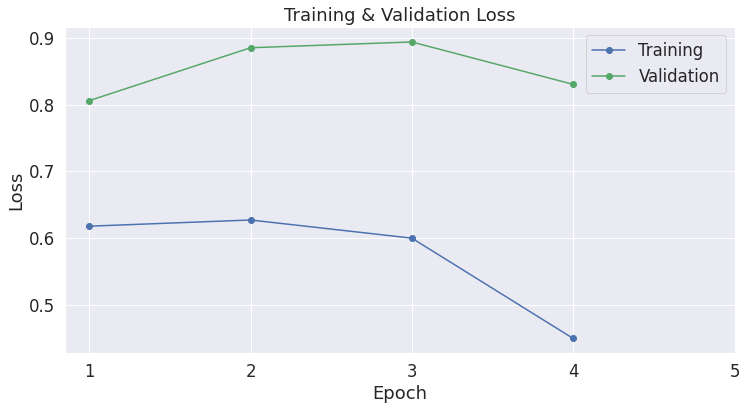

In [45]:
report_model_1(results_unbalanced)

In [46]:
results_balanced = train_val_gendermodel(train_loader=train_loader_balanced, val_loader=val_loader_balanced, epochs_val=4,seed_val=2020,device=device,lr_value=5e-5)

===========Starting Epoch 1 / 4 ==============
Training starts

  Average training loss: 0.70

Validation starts
  Accuracy: 0.55
  F1_score: 0.27
  Validation Loss: 0.69
===========Starting Epoch 2 / 4 ==============
Training starts

  Average training loss: 0.70

Validation starts
  Accuracy: 0.55
  F1_score: 0.27
  Validation Loss: 0.69
===========Starting Epoch 3 / 4 ==============
Training starts

  Average training loss: 0.70

Validation starts
  Accuracy: 0.45
  F1_score: 0.54
  Validation Loss: 0.70
===========Starting Epoch 4 / 4 ==============
Training starts

  Average training loss: 0.68

Validation starts
  Accuracy: 0.55
  F1_score: 0.27
  Validation Loss: 0.69

Done !


       Train Loss  Val Loss  Val Accur.    Val F1
epoch                                            
1        0.699993  0.687027    0.553333  0.266667
2        0.695709  0.687491    0.553333  0.266667
3        0.701363  0.695226    0.446667  0.542222
4        0.676579  0.687546    0.553333  0.266667


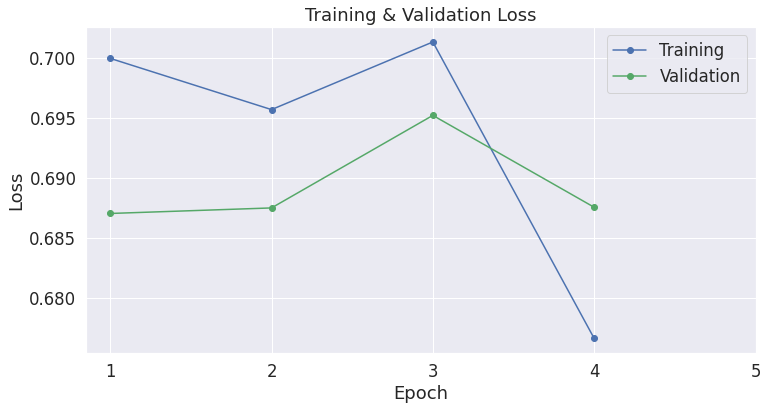

In [47]:
report_model_1(results_balanced)

In [48]:
results_balanced_split = train_val_gendermodel(train_loader=train_loader_balanced_split, val_loader=val_loader_balanced_split, epochs_val=4,seed_val=2020,device=device,lr_value=5e-5)

===========Starting Epoch 1 / 4 ==============
Training starts

  Average training loss: 0.69

Validation starts
  Accuracy: 0.65
  F1_score: 0.67
  Validation Loss: 0.62
===========Starting Epoch 2 / 4 ==============
Training starts

  Average training loss: 0.62

Validation starts
  Accuracy: 0.72
  F1_score: 0.65
  Validation Loss: 0.77
===========Starting Epoch 3 / 4 ==============
Training starts

  Average training loss: 0.48

Validation starts
  Accuracy: 0.80
  F1_score: 0.75
  Validation Loss: 0.74
===========Starting Epoch 4 / 4 ==============
Training starts

  Average training loss: 0.26

Validation starts
  Accuracy: 0.77
  F1_score: 0.71
  Validation Loss: 0.98

Done !


       Train Loss  Val Loss  Val Accur.    Val F1
epoch                                            
1        0.688840  0.624853    0.649606  0.666667
2        0.622899  0.768460    0.724409  0.645669
3        0.475001  0.742249    0.803150  0.753281
4        0.257250  0.975732    0.771654  0.713911


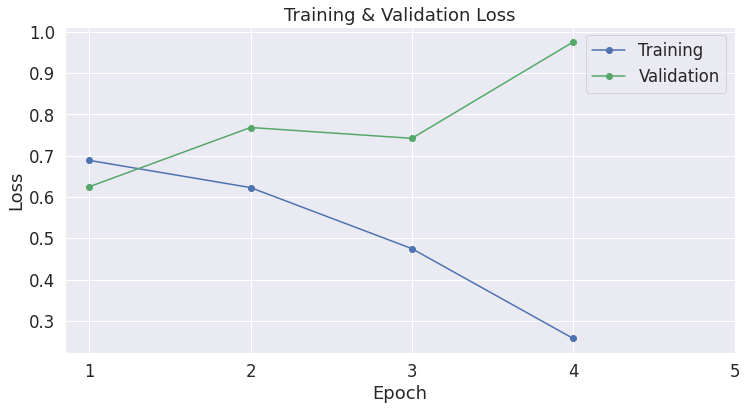

In [49]:
report_model_1(results_balanced_split)

Analyse

#### Training the optimal model 

In [586]:
df_eval= balanced_splitted(df,seed_val,frac_val=1,max_tokens=500
)

Number of text in this balanced splitted corpus : 10,121

Proportions of women in the balanced splitted corpus : 51.09178934887857



In [0]:
# We prepare another sample which will be dedicated to further qualitative analysis

In [588]:
len_train = round(0.97*len(df_eval))
df_balanced_split= df_eval[0:len_train]
dev_balanced_split=df_eval[len_train:len(df_eval)]

# Report the number of speeches in the corpus.
print('Number of text in this balanced splitted corpus : {:,}\n'.format(df_balanced_split.shape[0]))
print('Number of text in the development sample : {:,}\n'.format(dev_balanced_split.shape[0]))

Number of text in this balanced splitted corpus : 9,817

Number of text in the development sample : 304



In [589]:
train_loader_balanced_split, val_loader_balanced_split = prepare_to_feed(df_balanced_split,length=500,batch_size_value=16,length_train=0.9)

KeyboardInterrupt: ignored

In [0]:
############################  IMPORT MODEL ################################################
from transformers import CamembertForSequenceClassification
gender_model = CamembertForSequenceClassification.from_pretrained("camembert-base", 
                                                                  num_labels = 2, 
                                                                  output_attentions = False, 
                                                                  output_hidden_states = False, )

gender_model.cuda()
############################## RANDOM SEED ##################################################

import random
seed=seed_val
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed_all(seed)

############################### LEARNING RATE SCHEDULER #######################################

import torch.nn as nn
import torch.optim as optim
from transformers import AdamW
from transformers import get_linear_schedule_with_warmup

epochs = 3 

#Implements Adam algorithm with weight decay fix.
opti = AdamW(gender_model.parameters(),
              lr =5e-5, # learning rate (default = 1e-3)
              eps = 1e-8 # prevents division by 0 (default = 1e-8)
            )

num_training_steps = len(train_loader_balanced_split) * epochs

# Create a schedule with a learning rate that decreases linearly after linearly increasing during a warmup period (0 here)
scheduler = get_linear_schedule_with_warmup(opti, 
                                            num_warmup_steps = 0,
                                            num_training_steps = num_training_steps)


for ep in range(0, epochs):
  print('===========Starting Epoch {} / {} =============='.format(ep+1,epochs))
  print('Training starts')

  ################################### TRAINING ################################

  #Put the model in training mode
  gender_model.train()

  # Set the train loss for the epoch to 0 
  total_train_loss = 0

  for step, batch in enumerate(train_loader_balanced_split):
    # Clear gradients 
    gender_model.zero_grad() # (opti.zerograd ? )

    # Cpy the 3 batch to GPU 
    b_input_ids = batch[0].to(device)
    b_input_mask = batch[1].to(device)
    b_labels = batch[2].to(device)
    
    #return loss and logits
    loss, logits = gender_model(b_input_ids, 
                                token_type_ids=None, 
                                attention_mask=b_input_mask, 
                                labels=b_labels) 
    
    # Accumulate training loss for all batches 
    total_train_loss += loss.item()

    #Backpropagating the gradients 
    loss.backward()

    # Prevent exploding gradients problem  (forcing the gradients to be small, the parameter updates will not push the parameters too far from their previous values)
    torch.nn.utils.clip_grad_norm_(gender_model.parameters(), 1.0)

    # Update parameters 
    opti.step()

    # Update learning rate schedule
    scheduler.step()

  #Calculate the average training loss over all batches  
  avg_train_loss = total_train_loss / len(train_loader_balanced_split)
  print("")
  print("  Average training loss: {0:.2f}".format(avg_train_loss))

===========Starting Epoch 1 / 3 ==============
Training starts


Let's compute some statistics on the performance of this final model

In [0]:
 def evaluation_loop(model,eval_loader): 
  # Put model in evaluation mode 
  model.eval()
  total_eval_loss,total_pred,total_label,total_logits=[],[],[],[]

  for batch in eval_loader:
    b_input_ids = batch[0].to(device)
    b_input_mask = batch[1].to(device)
    b_labels = batch[2].to(device)

    with torch.no_grad(): 
      loss, logits = model(b_input_ids, 
                                token_type_ids=None, 
                                attention_mask=b_input_mask,
                                labels=b_labels)
    #total_eval_loss += loss.item()

      # Move logits and labels to CPU 
      logits = logits.detach().cpu().numpy()
      label_ids = b_labels.to('cpu').numpy()
      pred= np.argmax(logits, axis=1).flatten()
      labels_flat = label_ids.flatten()

    # Accumulation accuracy for all batch
      total_pred += pred.tolist()

    # Accumulation f1 for all batch
      total_label += labels_flat.tolist()

      # Logits score on positive 
      total_logits += logits.tolist()

  return total_pred,total_label,total_logits

In [0]:
total_pred,total_label,total_logits =evaluation_loop(gender_model,val_loader_balanced_split)

In [0]:
def model_report(pred,label,logits):
    """
        Input :
            model : Algorithme de sklearn avec les paramètres choisit ou par défaut
            X_train,X_test,y_train,y_test : dataset découpé à l'aide de train_test_split
        Output : 
            Classification_report + Confusion_matrix + ROC_curve + (si possible feature importance)
    """
    #from sklearn
    import seaborn as sns
    import matplotlib.pyplot as plt
    from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, roc_auc_score, roc_curve
    logits = [el[1] for el in total_logits]
    pred = [i for i in total_pred]
    label = [i for i in total_label]
    print ("Classification report :")
    print(classification_report(label,pred))
    print ("Accuracy : ",accuracy_score(label,pred))
    cm = confusion_matrix(label,pred)
    ROC = roc_auc_score(label,pred) 
    print ("AUC : ",ROC)
    fpr,tpr,thresholds = roc_curve(label,logits)
    plt.figure(figsize=(12,10))
    plt.subplot(221)
    sns.heatmap(cm/np.sum(cm), annot=True, 
            fmt='.2%', cmap='Blues').set_title('Matrice de confusion')
    plt.subplot(222)
    plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % ROC)
    plt.plot([0,1],[0,1],color='red')
    plt.title('Courbe ROC')
    plt.show()

Classification report :
              precision    recall  f1-score   support

           0       0.86      0.90      0.88       604
           1       0.90      0.86      0.88       623

    accuracy                           0.88      1227
   macro avg       0.88      0.88      0.88      1227
weighted avg       0.88      0.88      0.88      1227

Accuracy :  0.8777506112469438
AUC :  0.8780999861809445


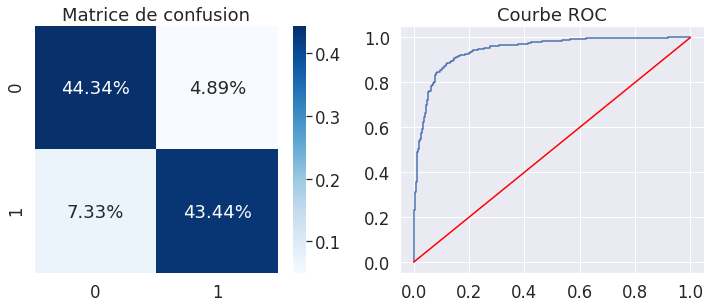

In [436]:
model_report(total_pred,total_label,logits)

## Evaluation and qualitative analysis 

Preparing development sequence 

We will use our development set we let outside of the analysis to make an attempt of qualitative analysis. 

In [0]:
# We prepare again the development sample for analysis 
def dev_prepare_to_feed(df,max_length_value,batch_size_value):
  from torch.utils.data import TensorDataset, random_split
  from torch.utils.data import DataLoader, RandomSampler, SequentialSampler
  from transformers import CamembertTokenizer

  texts = df.Texte.values
  labels = df.sexe.values
  tokenizer = CamembertTokenizer.from_pretrained('camembert-base', do_lower_case=False,padding_side='right')
  
  # Tokenize all of the sentences and map the tokens to thier word IDs.
  input_ids = []
  attention_masks = []
  num_truncated_tokens =[]

  for text in texts:
    encoded_dict = tokenizer.encode_plus(
                          text,                      # text
                          add_special_tokens = True, # Add '[CLS]' and '[SEP]'
                          max_length = max_length_value,           # We choose for now a max length of 500.
                          pad_to_max_length = True,    # Pad text to max (marche pas en pad left ?)
                          return_attention_mask = True,   # Construct attention masks
                          return_tensors = 'pt',     # Return pytorch tensors.
                          return_overflowing_tokens =True, # return overflowing token information
                    )
      
      # Map tokens to their id in the dictionnary 
      # We add this to our list    
    input_ids.append(encoded_dict['input_ids'])

      #num_truncated_tokens.append(encoded_dict['num_truncated_tokens'])
      
      # 3. Attention masks
    attention_masks.append(encoded_dict['attention_mask'])

  # We convert all this into tensors in order to be able to make it work on GPU 
  input_ids = torch.cat(input_ids, dim=0)
  attention_masks = torch.cat(attention_masks, dim=0)
  labels = torch.tensor(labels)

  # Original text and transformed tensor print 
  print("Let's check for the first text indexes, attention masks and labels")
  print(" ")
  print('Original: ', texts[0][0:100])
  print('IDs:', input_ids[0][0:100])
  print('Attention masks:', attention_masks[0][0:100])
  print('labels',labels[0])

  # Combine all above
  dataset = TensorDataset(input_ids, attention_masks, labels)
  # We create data loaders for the train and validation dataset. 
  dev_dataloader = DataLoader(
              dataset,  # The training samples.
              batch_size = batch_size_value, # Trains with this batch size.
              shuffle=False
          )
  return dev_dataloader

In [438]:
dev_dataloader=dev_prepare_to_feed(dev_balanced_split,max_length_value=500,batch_size_value=10)

Let's check for the first text indexes, attention masks and labels
 
Original:   d'Etats. Un nouveau référendum sera nécessaire en Espagne, par exemple.Est-ce que cela signifie que
IDs: tensor([    5,    18,    11,  1184,    10,     9,   153,   281, 12046,   210,
          885,    22,  5414,     7,    37,   411,     9,  2806,    26,   291,
           27,   207,  2106,    27,    16,   225,  7109,    37,    13,  7845,
          161,    17,   197,  4355,     8,  1598, 14419,  2722,    10,  6297,
           18,   197,  2806,    55,   402,     7,   264,    37,    13,    84,
         5807,     7,   711,   101,  5471,   106,  1260,    43,    44,   547,
           23,   225,  4946,     7,   174,    91,    48, 30122,     9,  6644,
           26,    62,    48, 11165,    20,  7718,  7869,     7,   174,    63,
          296,   117,     7,    14,   202,    16,   246,     7,  6725,    19,
        20384,    10,   106, 27173,    34,     9,    69,    63,   213,  5459])
Attention masks: tensor([1, 1, 1,

In [439]:
dev_balanced_split

,index,Texte,sexe,index_df
12262,6293,"d'Etats. Un nouveau référendum sera nécessaire en Espagne, par exemple.Est-ce que cela signifie...",0,160660
12263,2069,"honie mobile et l'Internet, ne doit pas concerner la TMP. Son réseau doit donc être complété par...",1,167839
12264,10738,"Monsieur le Président de la République, Cher Ali,Madame, Chère Sylvia,Mesdames, Messieurs et, si...",0,178330
12265,979,lons en particulier avec la Russie - le président Hollande et le président Poutine évoquent régu...,0,196163
12266,162,d'unités d'accueil dans les hôpitaux pour les enfants victimes d'abus sexuels. J'ai décidé de la...,0,147492
...,...,...,...,...
12636,1661,"ts à confort partagé ou des unités de vie, je tiens à me féliciter du travail de collaboration e...",1,187164
12637,2139,"elles n'ont aucune visibilité sur l'avenir, aucune possibilité d'emprunter afin d'investir pour...",1,204322
12638,11971,"Les prochains Albums seront présentés le 28 mars prochain sous l'égide de Frédéric Borel, derni...",0,184419
12639,7491,"porte au sein de l'Union européenne. Elle doit l'utiliser, en formant des coalitions à géométrie...",1,187707


In [0]:

# Put model in evaluation mode 
gender_model.eval()
total_eval_loss,total_pred,total_label,total_logits=[],[],[],[]

for batch in dev_dataloader:
  b_input_ids = batch[0].to(device)
  b_input_mask = batch[1].to(device)
  b_labels = batch[2].to(device)

  with torch.no_grad(): 
    loss, logits = gender_model(b_input_ids, 
                              token_type_ids=None, 
                              attention_mask=b_input_mask,
                              labels=b_labels)
  #total_eval_loss += loss.item()

    # Move logits and labels to CPU 
    logits = logits.detach().cpu().numpy()
    label_ids = b_labels.to('cpu').numpy()
    pred= np.argmax(logits, axis=1).flatten()
    labels_flat = label_ids.flatten()

  # Accumulation accuracy for all batch
    total_pred += pred.tolist()

  # Accumulation f1 for all batch
    total_label += labels_flat.tolist()

    # Logits score on positive 
    total_logits += logits.tolist()



In [0]:
total_pred,total_labels,total_logits=evaluation_loop(gender_model,dev_dataloader)


In [0]:
# Extract the score for label 1 
one_score = [el[1] for el in total_logits]
max_score = np.max(total_logits,axis=1)
# Put everything inside a dataframe
results_dev=pd.DataFrame([total_labels,total_pred,one_score,max_score]).transpose()
results_dev.columns=['returned_labels','model_pred','one_score','max_score']
results_dev['WF']=pd.DataFrame([results_dev['model_pred']==results_dev['returned_labels']]).transpose()
# Merge back with the text
frames = [dev_balanced_split[['Texte','sexe','index_df']].reset_index(), results_dev]
result = pd.concat(frames,axis=1)

In [581]:
result

,index,Texte,sexe,index_df,returned_labels,model_pred,one_score,max_score,WF
0,9850,de personnes fragiles et âgées. C'est le développement de programmes de prévention.Nous connaiss...,0,206738,1.0,1.0,1.661007,1.661007,True
1,9851,"pas très bien dans ce domaine. En ce qui concerne Airbus et le différend à l'OMC, nous sommes e...",1,271182,1.0,1.0,1.576719,1.576719,True
2,9852,"Contrats d'Objectifs et de Moyens (COM) apprentissage 2011-2015, je veille avec Xavier Bertrand ...",1,182420,1.0,1.0,0.611350,0.611350,True
3,9853,médecins de proximité - généralistes ou pas - sont les responsables des parcours de soins des pa...,1,185381,1.0,1.0,1.592562,1.592562,True
4,9854,de maîtriser nos consommations et de préserver notre indépendance énergétique - ce qui me condui...,0,141782,1.0,0.0,-1.530968,1.536042,False
...,...,...,...,...,...,...,...,...,...
300,10150,des dotations comparables à celles prévues par la loi programme sur les monuments historiques 19...,1,130907,NaN,NaN,NaN,NaN,NaN
301,10151,du montant total de contrats de recherche est remarquable : 17 % par an depuis 2010 ! Et même de...,1,189967,NaN,NaN,NaN,NaN,NaN
302,10152,"en cause des politiques communes et, par là, sur une véritable régression du projet européen.C'e...",1,139956,NaN,NaN,NaN,NaN,NaN
303,10153,"solidarité. Eh bien, je préfère la solidarité et comme vous le savez, nous plaçons avec le prési...",0,270298,NaN,NaN,NaN,NaN,NaN


In [582]:
#Which texts failed ? 
print('{0:.2f} percent of the development texts were not well classified by our model'.format(result[result.WF==False].WF.count()*100/len(result)))

0.33 percent of the development texts were not well classified by our model


In [0]:
# We merge this dataframe to the information we had at the beginning
merged_results=result[['index','index_df','returned_labels','model_pred','one_score','max_score','WF']].merge(df,how='left',left_on='index_df',right_on='Id')

Now we are going to take 3 texts well classified and 3 other wrongly classified. We will try to take the ones the model as really sure about in the good or bad side.

In [0]:
top_texts_true=merged_results[merged_results.WF==1].nlargest(3,'max_score')
top_texts_false=merged_results[merged_results.WF==0].nlargest(3,'max_score')

In [525]:
top_texts_true

,index,Texte_x,sexe_x,index_df,returned_labels,model_pred,one_score,max_score,WF,Unnamed: 0,Id,Titre,Type,Theme,Prenom,Nom,Fonction,Date,Tags,Texte_y,Lien,PRENOM,preusuel,sexe_y
260,12522,"peut être utile car je suis sûr que vous avez tous rencontré des jeunes qui vous ont dit : ""Dan...",0,136461,0.0,0.0,-2.259665,2.345746,True,19839,136461,"Déclaration de M. Alain Juppé, Premier ministre sur la volonté de réforme du gouvernement et les...",déclaration,Institutions,Alain,Juppé,NaN,1997-01-11T12:00:00Z,"Institutions de l'Etat,Politique gouvernementale","M. JUPPÉ.- ... Le Conseil Régional d'Aquitaine, puisque nous sommes ici au RELPA, c'est-à-dire l...",https://www.vie-publique.fr/discours/136461-declaration-de-m-alain-juppe-premier-ministre-sur-la...,ALAIN,ALAIN,0
287,12549,"Madame la ministre, chère Amélie, Mesdames les Ambassadrices, Messieurs les Ambassadeurs, Mesd...",0,272782,0.0,0.0,-2.260156,2.345734,True,758,272782,"Déclaration de M. Jean-Yves Le Drian, ministre de l'Europe et des affaires étrangères, sur les d...",déclaration,International,Jean-Yves,Le Drian,-Ministre de l'Europe et des affaires étrangères,2020-01-14T12:00:00Z,"Relations internationales,Politique étrangère","Madame la ministre, chère Amélie, Mesdames les Ambassadrices, Messieurs les Ambassadeurs, Mesd...",https://www.vie-publique.fr/discours/272782-jean-yves-le-drian-14012020-politique-etrangere,JEAN-YVES,JEAN-YVES,0
75,12337,n : - d'importantes disparités entre les collectivités posent la question fondamentale du princi...,0,189368,0.0,0.0,-2.259712,2.345652,True,34319,189368,"Déclaration de M. Raymond Forni, président de l'Assemblée nationale, sur l'importance de la déce...",déclaration,NaN,Raymond,Forni,NaN,2001-10-04T12:00:00Z,NaN,"Monsieur le Président, Mesdames, Messieurs les élus,Permettez-moi tout d'abord de vous dire mon ...",https://www.vie-publique.fr/discours/189368-declaration-de-m-raymond-forni-president-de-lassembl...,RAYMOND,RAYMOND,0


In [450]:
top_texts_false

,index,Texte_x,sexe_x,index_df,returned_labels,model_pred,one_score,max_score,WF,Unnamed: 0,Id,Titre,Type,Theme,Prenom,Nom,Fonction,Date,Tags,Texte_y,Lien,PRENOM,preusuel,sexe_y
368,12630,e les officiers doivent maîtriser ; celui de la consolidation du socle de formation militaire qu...,1,149408,1.0,0.0,-2.253336,2.341088,False,25674,149408,"Déclaration de Mme Michèle Alliot-Marie, ministre de la défense, sur l'Ecole des officiers de ge...",déclaration,Société,Michèle,Alliot-Marie,NaN,2005-10-01T12:00:00Z,"Sécurité,Gendarmerie","Monsieur le Directeur général,Messieurs les officiers généraux,Mesdames et Messieurs les élus,Mo...",https://www.vie-publique.fr/discours/149408-declaration-de-mme-michele-alliot-marie-ministre-de-...,MICHÈLE,MICHÈLE,1
55,12317,"s sujets les plus sensibles, constituent des progrès notables.Chacun de ses trois départements a...",1,168186,1.0,0.0,-2.251326,2.339003,False,25518,168186,"Déclaration de Mme Michèle Alliot-Marie, ministre de l'intérieur, de l'outre-mer et des collecti...",déclaration,NaN,Michèle,Alliot-Marie,NaN,2007-10-16T12:00:00Z,NaN,"Mesdames et Messieurs les Parlementaires,Mesdames et Messieurs les élus,Monsieur le Président et...",https://www.vie-publique.fr/discours/168186-declaration-de-mme-michele-alliot-marie-ministre-de-...,MICHÈLE,MICHÈLE,1
73,12335,"rs prioritaires de la politique de la ville. Dans les agglomérations concernées, le contrat doit...",1,195136,1.0,0.0,-2.227067,2.317083,False,18512,195136,"Déclaration de Mme Myriam El Khomri, secrétaire d'Etat à la politique de la ville, sur la négoci...",déclaration,Société,Myriam,El Khomri,NaN,2015-05-26T12:00:00Z,"Ville - Territoires,Urbanisme","Ce séminaire des réseaux déconcentrés de l'Etat pour les politiques de la ville, de la jeunesse ...",https://www.vie-publique.fr/discours/195136-declaration-de-mme-myriam-el-khomri-secretaire-detat...,MYRIAM,MYRIAM,1


We want to dive a bit into the model and see how it makes a choice and why it fails on thos 38 sentences. Let's take one of them. We will redo point 4 of TD4 to see the score reached by each word. 

In [0]:
def split_document_to_limit(MAX_TOKENS,df):
  lst= []
  for index,row in df.iterrows():
    identifiant = row.Id
    label = row.sexe
    phrase = []
    for token in row.Texte.split(' '):
      if len(phrase) < MAX_TOKENS:
        phrase.append(token)
      else:
        lst += [(identifiant,label,' '.join(phrase),len(phrase))]
        phrase = []
    if len(phrase)>1:
      lst += [(identifiant,label,' '.join(phrase),len(phrase))]
  return pd.DataFrame(lst,columns=['index_df','sexe','Texte','Length'])
def split_document_to_limit_phrases(MAX_TOKENS,df):
  lst= []
  for index,row in df.iterrows():
    identifiant = row.Id
    label = row.sexe
    phrase = ''
    for phrases in sent_detector_mano(row.Texte):
      if len(phrase.split(' ')) + len(phrases.split(' ')) < MAX_TOKENS:
        phrase+= " " + phrases
      else:
        lst += [(identifiant,label,phrase,len(phrase.split(' ')))]
        phrase = ''
    lst += [(identifiant,label,phrase,len(phrase.split(' ')))]
    phrase = ''
  return pd.DataFrame(lst,columns=['index_df','sexe','Texte','Length'])

In [573]:
sentence_to_analyse = pd.concat([top_texts_false,top_texts_true]).reset_index(drop=True)
sentence_to_analyse=split_document_to_limit_phrases(50,sentence_to_analyse)

AttributeError: ignored

In [570]:
sexe

[1, 1, 1, 0, 0, 0]

In [565]:
tokens

[["e les officiers doivent maîtriser ; celui de la consolidation du socle de formation militaire qui forge votre savoir-être, qui vous vaut l'estime de la Nation",
  "A cet égard, je ne veux pas que vous soyez écartés de l'honneur de servir la Défense à l'extérieur du territoire et d'exprimer aussi de cette façon votre vocation militaire",
  'Je souhaite que chaque officier de gendarmerie participe au moins une fois au cours de sa carrière à une opération extérieure',
  "L'EOGN doit demeurer la maison mère de tous les officiers servant en gendarmerie",
  ' Pour autant, elle devra également adapter ses cursus au nombre de stagiaires, à la diversité grandissante de leurs origines et à la diversité des recrutements',
  'C\'est ce qui fera de cette grande école de service public un véritable " campus de défense ", comparable à celui des Ecoles de Coëtquidan',
  "Ce n'est pas une moindre mission de la gendarmerie nationale que d'être partout sur le territoire français le témoin de la Républ

In [558]:
sentences_to_analyse =pd.DataFrame(tokens)
sentences_to_analyse.columns=['Texte','sexe']


ValueError: ignored

In [531]:
sentences_to_analyse

,Texte,sexe
0,n : - d'importantes disparités entre les collectivités posent la question fondamentale du princi...,1
1,Les principes du nouvel élan de la décentralisationLa décentralisation recherche aujourd'hui un ...,1
2,Je suis convaincu que nous trouverons l'élan nécessaire si nous réussissons à opérer trois synt...,1
3,Il doit évidemment conserver l'autorité nécessaire pour faire respecter le principe d'égalité t...,1
4,"Je pense, ici, à la nécessité de concilier l'augmentation des moyens et des responsabilités des...",1
5,"En faisant adopter par le Parlement un contrat de croissance et de solidarité, en 1998, le Gouv...",1
6,Ce contrat sera prolongé pour 2002,1
7,Cet engagement sur une période longue tranche avec des pratiques antérieures où les dotations a...,1
8,Je serai heureux d'entendre les propositions que vous pourrez légitimement formuler aujourd'hui...,1


In [0]:
from torch.utils.data import TensorDataset, random_split
from torch.utils.data import DataLoader, RandomSampler, SequentialSampler


texts = sentences_to_analyse.Texte.values
labels = sentences_to_analyse.sexe.values

In [0]:
# Tokenize all of the sentences and map the tokens to thier word IDs.
input_ids = []
attention_masks = []
num_truncated_tokens =[]
original_text =[]
tokenized_text=[]

for text in texts:
  original_text.append(text)
  tokenized_text.append(tokenizer.tokenize(text))
  encoded_dict = tokenizer.encode_plus(
                        text,                      # text
                        add_special_tokens = True, # Add '[CLS]' and '[SEP]'
                        max_length = 50,           # We choose for now a max length of 500.
                        pad_to_max_length = True,    # Pad text to max (marche pas en pad left ?)
                        return_attention_mask = True,   # Construct attention masks
                        return_tensors = 'pt',     # Return pytorch tensors.
                        return_overflowing_tokens =True, # return overflowing token information
                  )
    
    # Map tokens to their id in the dictionnary 
    # We add this to our list    
  input_ids.append(encoded_dict['input_ids'])

    #num_truncated_tokens.append(encoded_dict['num_truncated_tokens'])
    
    # 3. Attention masks
  attention_masks.append(encoded_dict['attention_mask'])

In [0]:
# We convert all this into tensors in order to be able to make it work on GPU 
input_ids = torch.cat(input_ids, dim=0)
attention_masks = torch.cat(attention_masks, dim=0)
labels = torch.tensor(labels)

In [0]:
# Combine all above
batch_size = 1
dataset = TensorDataset(input_ids, attention_masks, labels)
# We create data loaders for the train and validation dataset. 
dev_dataloader = DataLoader(
            dataset,  # The training samples.
            sampler = SequentialSampler(dataset), # We set to sequential and we keep track 
            batch_size = batch_size # Trains with this batch size.
        )

In [0]:
total_pred,total_labels,total_logits =dev_eval(gender_model,dev_dataloader)

In [0]:
# Extract the score for label 1 
one_score = [el[1] for el in total_logits]

In [0]:
results_dev=pd.DataFrame([total_labels,total_pred,one_score]).transpose()
results_dev.columns=['returned_labels','model_pred','one_score']

In [0]:
frames = [sentences_to_analyse.reset_index(), results_dev]
result = pd.concat(frames,axis=1)

In [541]:
result[result.sexe!=result.model_pred]

,index,Texte,sexe,returned_labels,model_pred,one_score


In [0]:
words_to_analyse = [i for i in result[6:7].Texte.str.split(' ')]

In [543]:
words_to_analyse

[['', 'Ce', 'contrat', 'sera', 'prolongé', 'pour', '2002']]

Now let's put in the model just one sentence and see how it behaves

In [0]:
words_to_analyse=pd.DataFrame(words_to_analyse).transpose()
words_to_analyse=words_to_analyse.assign(sexe=1)
words_to_analyse.columns=['Texte','sexe']


In [545]:
words_to_analyse.head()

,Texte,sexe
0,,1
1,Ce,1
2,contrat,1
3,sera,1
4,prolongé,1


In [0]:
from torch.utils.data import TensorDataset, random_split
from torch.utils.data import DataLoader, RandomSampler, SequentialSampler


texts = words_to_analyse.Texte.values
labels = words_to_analyse.sexe.values

# Tokenize all of the sentences and map the tokens to thier word IDs.
input_ids = []
attention_masks = []
num_truncated_tokens =[]
original_text =[]
tokenized_text=[]

for text in texts:
  original_text.append(text)
  tokenized_text.append(tokenizer.tokenize(text))
  encoded_dict = tokenizer.encode_plus(
                        text,                      # text
                        add_special_tokens = True, # Add '[CLS]' and '[SEP]'
                        max_length = 5,           # We choose for now a max length of 500.
                        pad_to_max_length = True,    # Pad text to max (marche pas en pad left ?)
                        return_attention_mask = True,   # Construct attention masks
                        return_tensors = 'pt',     # Return pytorch tensors.
                        return_overflowing_tokens =True, # return overflowing token information
                  )
    
    # Map tokens to their id in the dictionnary 
    # We add this to our list    
  input_ids.append(encoded_dict['input_ids'])

    #num_truncated_tokens.append(encoded_dict['num_truncated_tokens'])
    
    # 3. Attention masks
  attention_masks.append(encoded_dict['attention_mask'])

In [0]:
# We convert all this into tensors in order to be able to make it work on GPU 
input_ids = torch.cat(input_ids, dim=0)
attention_masks = torch.cat(attention_masks, dim=0)
labels = torch.tensor(labels)

In [0]:
# Combine all above
batch_size = 1
dataset = TensorDataset(input_ids, attention_masks, labels)
# We create data loaders for the train and validation dataset. 
dev_dataloader = DataLoader(
            dataset,  # The training samples.
            sampler = SequentialSampler(dataset), # We set to sequential and we keep track 
            batch_size = batch_size # Trains with this batch size.
        )

In [0]:

total_labels,total_pred,total_logits =dev_eval(gender_model,dev_dataloader)

In [0]:
# Extract the score for label 1 
one_score = [el[1] for el in total_logits]
results_dev_word=pd.DataFrame([total_labels,total_pred,one_score]).transpose()
results_dev_word.columns=['returned_labels','model_pred','one_score']

In [551]:
results_dev_word

,returned_labels,model_pred,one_score
0,1.0,1.0,1.661007
1,1.0,1.0,1.576719
2,1.0,1.0,0.611350
3,1.0,1.0,1.592562
4,1.0,0.0,-1.530968
5,1.0,1.0,1.304985
6,1.0,1.0,1.579299


In [0]:
frames = [words_to_analyse.reset_index(), results_dev_word]
results_dev_word = pd.concat(frames,axis=1)

In [553]:
results_dev_word.head()

,index,Texte,sexe,returned_labels,model_pred,one_score
0,0,,1,1.0,1.0,1.661007
1,1,Ce,1,1.0,1.0,1.576719
2,2,contrat,1,1.0,1.0,0.611350
3,3,sera,1,1.0,1.0,1.592562
4,4,prolongé,1,1.0,0.0,-1.530968


In [0]:
scores = [i for i in results_dev_word['one_score']]

In [0]:
df_plot= results_dev_word[['one_score']].transpose()

In [0]:
df_plot.columns=list(results_dev_word.Texte)

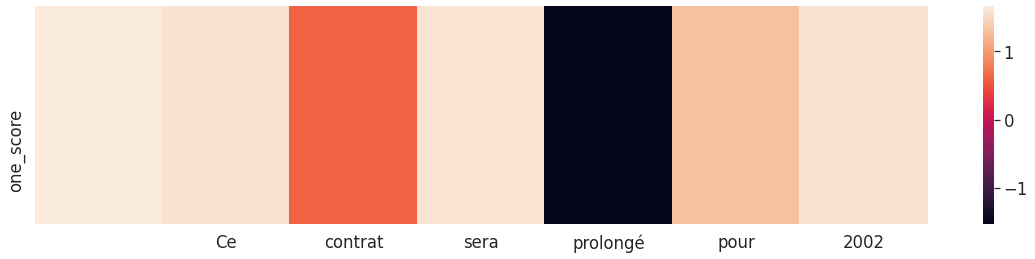

In [557]:
import seaborn as sns
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

 
# Default heatmap: just a visualization of this square matrix
fig, ax = plt.subplots(figsize=(20,4)) 
sns.heatmap(df_plot)
plt.show()


Faire des annotations pour la fin du doc et nettoyer mettre en forme
Faire des fonctions pour la fin 
Amélioer le graphique . Est ce que c'est intelligent par mot ? 
Remplacer score max par la moyenne des logits à chercher à la fin du train 
Analyser un peu et mettre au propre sur la feuille
